In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import zscore
import matplotlib.pyplot as plt 
from statsmodels import regression
from statsmodels.tsa.stattools import coint

In [2]:
data = pd.read_excel('dados_relatorio_final.xlsx')

In [7]:
data

,time,IBOV,ABEV3,BBAS3,BBDC3,BBDC4,BBSE3,BRAP4,BRFS3,BRKM5,...,RAIL3,SANB11,SBSP3,SMLS3,TIMP3,UGPA3,USIM5,VALE3,VIVT4,WEGE3
0,2016-01-22,38031,15.08,10.96,8.96,8.37,15.14,2.71,46.38,19.54,...,1.50,10.67,17.21,20.57,5.60,25.66,0.95,8.17,25.62,10.47
1,2016-01-26,37497,15.07,10.87,8.96,8.27,14.47,2.71,45.02,19.09,...,1.50,10.32,17.47,19.86,5.42,24.80,0.92,8.09,25.21,10.08
2,2016-01-27,38376,15.94,10.71,9.14,8.37,14.51,2.80,45.93,19.39,...,1.67,10.38,18.23,20.65,5.72,25.61,0.86,8.51,26.04,10.49
3,2016-01-28,38630,16.01,10.95,9.30,8.39,14.98,2.71,45.54,19.00,...,1.77,10.43,18.42,20.76,5.49,25.82,0.82,8.44,25.62,10.46
4,2016-01-29,40406,16.70,11.68,9.49,8.75,15.93,2.87,47.59,19.57,...,1.89,10.67,18.83,21.61,5.78,26.60,0.81,8.79,26.24,10.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
969,2019-12-20,115121,18.91,50.45,30.07,32.21,34.54,37.23,34.81,28.38,...,25.67,44.79,58.02,38.50,15.20,24.30,9.24,53.59,55.25,33.63
970,2019-12-23,115863,18.96,51.98,30.68,32.41,34.73,37.77,34.53,29.25,...,25.94,44.80,58.36,38.93,15.31,25.01,9.44,53.38,55.74,33.56
971,2019-12-26,117203,19.22,52.57,31.00,32.81,34.56,38.37,35.18,30.17,...,26.60,45.74,59.90,39.21,15.51,25.28,9.44,53.59,56.23,34.62
972,2019-12-27,116534,19.16,52.34,30.80,32.68,34.63,38.49,35.24,30.44,...,26.87,45.87,60.11,39.46,15.51,25.40,9.34,53.60,55.84,35.10


In [4]:
class senninha_long_and_short():
    def __init__(self,dados,t1,t2, financeiro_inicial, zs_l):
        #temos o par de tickers, os dados históricos de preço, e as variações históricas.
        self.zs_critico = zs_l
        self.t1, self.t2 = t1,t2
        self.dados = dados[['time',t1,t2]]
        self.dados_var = dados[[t1,t2]].pct_change()[1:]
        self.dados = self.dados[1:]
        self.s1, self.s2 = self.dados[self.t1], self.dados[self.t2]
        self.s1_var, self.s2_var = self.dados_var[self.t1], self.dados_var[self.t2]
        self.financeiro = financeiro_inicial
        #variaveis iniciais para tradar pares
        self.posicionado = 0
        self.compra_s1 = 0
        self.venda_s2 = 0
        #desempenho ao longo do tempo 
        self.l_resultado = []
        self.l_pct_operacoes = []
          
    def calcula_zscore_spread(self,stock1,stock2):
        stock1 = sm.add_constant(stock1)
        results = sm.OLS(stock2,stock1).fit()
        stock1 = stock1[self.t1]
        b = results.params[self.t1]
        spread = stock2 - (b*stock1)
        zs = zscore(spread)[-1]
        return zs, b
    
    def print_resultados(self, tipo, r): #rlong,rshort,result
        if tipo == 'entrada':
            print(f'entrou | V1 {self.venda_s1:.2f} X {self.v1} | C2 {self.compra_s2:.2f} X {self.v2}')
        elif tipo == 'saida':
            print(f'saiu   | C1 {self.compra_s1:.2f} X {self.v1} | V2 {self.venda_s2:.2f} X {self.v2}')
        elif tipo == 'resultado':
            print(f'result | s1 {r[0]:.2f} | s2 {r[1]:.2f} | l/p = {r[2]:.2f}\n')
    
    def condicoes_operar(self, zs_atual, cotacao1, cotacao2):
        if zs_atual >= self.zs_critico and self.posicionado == 0:
            razao = cotacao1/cotacao2
            volume = (self.financeiro/2)//cotacao1
            self.v1, self.v2 = int(volume), int(razao*volume)
            #definiu o numero de ações que comprará de cada
            self.venda_s1 = cotacao1*self.v1
            self.compra_s2  = cotacao2*self.v2 
            self.valor_total_trade = self.venda_s1+self.compra_s2
            self.print_resultados('entrada',r=None)
            self.posicionado = 1
        elif zs_atual <= 0.08 and self.posicionado == 1:
            self.posicionado = 0            
            #encerra posicao
            self.compra_s1 = cotacao1*self.v1
            self.venda_s2  = cotacao2*self.v2 
            self.print_resultados('saida',r=None)
            #resultado
            resultado_long  = self.venda_s1 - self.compra_s1
            resultado_short = self.venda_s2 - self.compra_s2
            resultado = resultado_long + resultado_short
            pct_operacao = (resultado/self.valor_total_trade)*100
            #resultados ao longo do tempo
            self.l_pct_operacoes.append(pct_operacao)
            self.l_resultado.append(resultado)
            self.print_resultados('resultado',[resultado_long,resultado_short,resultado])
            self.financeiro += resultado
            #reseta valor em carteira de cada ação
            self.compra_s1, self.venda_s1, self.compra_s2 ,self.venda_s2,  = 0, 0, 0, 0
            resultado, resultado_long, resultado_short = 0, 0, 0
            
    def loop_operador(self, window_size):
        c = 0
        for index in range(window_size, len(self.s1)):
            #stock data in the window range
            s1_var_w, s2_var_w = self.s1_var[c:index], self.s2_var[c:index]
            preco_s1, preco_s2 = self.s1[self.dados.index == index].values[0], self.s2[self.dados.index == index].values[0]
            #calculates the zscore of the spread
            resultado_funcao = self.calcula_zscore_spread(s1_var_w, s2_var_w)
            zs, beta = resultado_funcao[0], resultado_funcao[1]
            self.condicoes_operar(zs_atual=zs, cotacao1=preco_s1, cotacao2=preco_s2)   
            c+=1

In [5]:
zsl = 1.1
dic_dados_pares = {}

tickers = [['VALE3','ITSA4'],['ECOR3','GOAU4'],['CSNA3','MRFG3'],['QUAL3','USIM5']] #['close VALE3','close ITSA4'],['close BBAS3','close BBSE3'],['close BBDC4','close ITUB4']
for i in tickers:
    dic_dados_pares[str(i)] = senninha_long_and_short(data,i[0], i[1], 1000,zs_l = zsl)
    dic_dados_pares[str(i)].loop_operador(window_size=45)

entrou | V1 499.46 X 34 | C2 498.96 X 99
saiu   | C1 521.90 X 34 | V2 499.95 X 99
result | s1 -22.44 | s2 0.99 | l/p = -21.45

entrou | V1 487.90 X 34 | C2 483.92 X 92
saiu   | C1 490.28 X 34 | V2 481.16 X 92
result | s1 -2.38 | s2 -2.76 | l/p = -5.14

entrou | V1 479.68 X 32 | C2 479.04 X 96
saiu   | C1 432.64 X 32 | V2 464.64 X 96
result | s1 47.04 | s2 -14.40 | l/p = 32.64

entrou | V1 495.72 X 36 | C2 494.90 X 101
saiu   | C1 497.52 X 36 | V2 487.83 X 101
result | s1 -1.80 | s2 -7.07 | l/p = -8.87

entrou | V1 495.00 X 33 | C2 495.00 X 99
saiu   | C1 454.08 X 33 | V2 483.12 X 99
result | s1 40.92 | s2 -11.88 | l/p = 29.04

entrou | V1 511.56 X 36 | C2 507.96 X 102
saiu   | C1 552.60 X 36 | V2 527.34 X 102
result | s1 -41.04 | s2 19.38 | l/p = -21.66

entrou | V1 497.76 X 34 | C2 496.32 X 94
saiu   | C1 518.50 X 34 | V2 496.32 X 94
result | s1 -20.74 | s2 0.00 | l/p = -20.74

entrou | V1 483.60 X 30 | C2 478.80 X 90
saiu   | C1 470.40 X 30 | V2 497.70 X 90
result | s1 13.20 | s2 18.

saiu   | C1 412.72 X 7 | V2 414.07 X 47
result | s1 -2.66 | s2 9.40 | l/p = 6.74

entrou | V1 418.18 X 7 | C2 412.65 X 45
saiu   | C1 401.80 X 7 | V2 423.00 X 45
result | s1 16.38 | s2 10.35 | l/p = 26.73

entrou | V1 445.52 X 8 | C2 443.25 X 45
saiu   | C1 450.56 X 8 | V2 439.65 X 45
result | s1 -5.04 | s2 -3.60 | l/p = -8.64

entrou | V1 450.88 X 8 | C2 447.30 X 45
saiu   | C1 459.52 X 8 | V2 443.25 X 45
result | s1 -8.64 | s2 -4.05 | l/p = -12.69

entrou | V1 420.96 X 8 | C2 418.74 X 42
saiu   | C1 443.20 X 8 | V2 416.22 X 42
result | s1 -22.24 | s2 -2.52 | l/p = -24.76

entrou | V1 427.04 X 8 | C2 417.79 X 41
saiu   | C1 428.64 X 8 | V2 413.69 X 41
result | s1 -1.60 | s2 -4.10 | l/p = -5.70

entrou | V1 438.80 X 8 | C2 433.37 X 41
saiu   | C1 426.16 X 8 | V2 428.45 X 41
result | s1 12.64 | s2 -4.92 | l/p = 7.72

entrou | V1 438.84 X 9 | C2 437.06 X 41
saiu   | C1 464.22 X 9 | V2 446.08 X 41
result | s1 -25.38 | s2 9.02 | l/p = -16.36

entrou | V1 408.72 X 8 | C2 404.04 X 37
saiu   

entrou | V1 393.20 X 40 | C2 388.36 X 76
saiu   | C1 386.40 X 40 | V2 387.60 X 76
result | s1 6.80 | s2 -0.76 | l/p = 6.04

entrou | V1 396.48 X 42 | C2 392.70 X 77
saiu   | C1 397.32 X 42 | V2 411.95 X 77
result | s1 -0.84 | s2 19.25 | l/p = 18.41

entrou | V1 409.08 X 42 | C2 406.80 X 72
saiu   | C1 416.64 X 42 | V2 419.04 X 72
result | s1 -7.56 | s2 12.24 | l/p = 4.68

entrou | V1 409.50 X 39 | C2 404.32 X 76
saiu   | C1 421.98 X 39 | V2 409.64 X 76
result | s1 -12.48 | s2 5.32 | l/p = -7.16

entrou | V1 404.70 X 38 | C2 402.00 X 75
saiu   | C1 417.62 X 38 | V2 395.25 X 75
result | s1 -12.92 | s2 -6.75 | l/p = -19.67

entrou | V1 393.48 X 36 | C2 389.60 X 80
saiu   | C1 379.80 X 36 | V2 372.80 X 80
result | s1 13.68 | s2 -16.80 | l/p = -3.12

entrou | V1 390.66 X 34 | C2 387.18 X 81
saiu   | C1 397.46 X 34 | V2 389.61 X 81
result | s1 -6.80 | s2 2.43 | l/p = -4.37

entrou | V1 393.40 X 35 | C2 389.60 X 80
saiu   | C1 390.60 X 35 | V2 385.60 X 80
result | s1 2.80 | s2 -4.00 | l/p = -

entrou | V1 369.75 X 25 | C2 367.65 X 43
saiu   | C1 380.25 X 25 | V2 363.78 X 43
result | s1 -10.50 | s2 -3.87 | l/p = -14.37

entrou | V1 497.70 X 79 | C2 495.80 X 74
saiu   | C1 479.53 X 79 | V2 470.64 X 74
result | s1 18.17 | s2 -25.16 | l/p = -6.99

entrou | V1 492.10 X 74 | C2 486.75 X 75
saiu   | C1 530.58 X 74 | V2 477.75 X 75
result | s1 -38.48 | s2 -9.00 | l/p = -47.48

entrou | V1 472.50 X 42 | C2 467.28 X 72
saiu   | C1 472.92 X 42 | V2 465.12 X 72
result | s1 -0.42 | s2 -2.16 | l/p = -2.58

entrou | V1 468.72 X 56 | C2 466.94 X 74
saiu   | C1 408.80 X 56 | V2 461.76 X 74
result | s1 59.92 | s2 -5.18 | l/p = 54.74

entrou | V1 491.64 X 68 | C2 489.44 X 76
saiu   | C1 487.56 X 68 | V2 487.16 X 76
result | s1 4.08 | s2 -2.28 | l/p = 1.80

entrou | V1 498.19 X 77 | C2 494.34 X 77
saiu   | C1 487.41 X 77 | V2 478.17 X 77
result | s1 10.78 | s2 -16.17 | l/p = -5.39

entrou | V1 494.00 X 76 | C2 488.88 X 84
saiu   | C1 490.20 X 76 | V2 480.48 X 84
result | s1 3.80 | s2 -8.40 | l/

entrou | V1 507.15 X 63 | C2 505.96 X 91
saiu   | C1 502.74 X 63 | V2 495.95 X 91
result | s1 4.41 | s2 -10.01 | l/p = -5.60

entrou | V1 506.81 X 59 | C2 502.85 X 89
saiu   | C1 536.31 X 59 | V2 505.52 X 89
result | s1 -29.50 | s2 2.67 | l/p = -26.83

entrou | V1 491.94 X 54 | C2 491.92 X 86
saiu   | C1 500.58 X 54 | V2 485.90 X 86
result | s1 -8.64 | s2 -6.02 | l/p = -14.66

entrou | V1 490.25 X 53 | C2 485.52 X 84
saiu   | C1 490.78 X 53 | V2 506.52 X 84
result | s1 -0.53 | s2 21.00 | l/p = 20.47

entrou | V1 493.17 X 51 | C2 493.08 X 84
saiu   | C1 465.12 X 51 | V2 487.20 X 84
result | s1 28.05 | s2 -5.88 | l/p = 22.17

entrou | V1 503.36 X 52 | C2 500.00 X 80
saiu   | C1 494.52 X 52 | V2 486.40 X 80
result | s1 8.84 | s2 -13.60 | l/p = -4.76

entrou | V1 508.68 X 54 | C2 505.60 X 79
saiu   | C1 468.72 X 54 | V2 494.54 X 79
result | s1 39.96 | s2 -11.06 | l/p = 28.90

entrou | V1 519.75 X 55 | C2 516.20 X 89
saiu   | C1 527.45 X 55 | V2 502.85 X 89
result | s1 -7.70 | s2 -13.35 | l

saiu   | C1 518.94 X 18 | V2 512.12 X 62
result | s1 3.24 | s2 -1.86 | l/p = 1.38

entrou | V1 530.64 X 18 | C2 523.74 X 58
saiu   | C1 539.64 X 18 | V2 518.52 X 58
result | s1 -9.00 | s2 -5.22 | l/p = -14.22

entrou | V1 508.30 X 17 | C2 504.60 X 60
saiu   | C1 513.57 X 17 | V2 522.00 X 60
result | s1 -5.27 | s2 17.40 | l/p = 12.13

entrou | V1 537.12 X 18 | C2 531.06 X 53
saiu   | C1 526.68 X 18 | V2 529.47 X 53
result | s1 10.44 | s2 -1.59 | l/p = 8.85

entrou | V1 540.60 X 20 | C2 534.44 X 62
saiu   | C1 536.00 X 20 | V2 487.94 X 62
result | s1 4.60 | s2 -46.50 | l/p = -41.90

entrou | V1 525.54 X 19 | C2 518.50 X 61
saiu   | C1 509.77 X 19 | V2 505.08 X 61
result | s1 15.77 | s2 -13.42 | l/p = 2.35

entrou | V1 524.60 X 20 | C2 517.56 X 57
saiu   | C1 520.60 X 20 | V2 518.13 X 57
result | s1 4.00 | s2 0.57 | l/p = 4.57

entrou | V1 522.90 X 21 | C2 521.92 X 56
saiu   | C1 538.02 X 21 | V2 545.44 X 56
result | s1 -15.12 | s2 23.52 | l/p = 8.40

entrou | V1 522.06 X 21 | C2 514.01 X

['VALE3', 'ITSA4']: 932.39
['ECOR3', 'GOAU4']: 744.22
['CSNA3', 'MRFG3']: 988.80
['QUAL3', 'USIM5']: 845.84


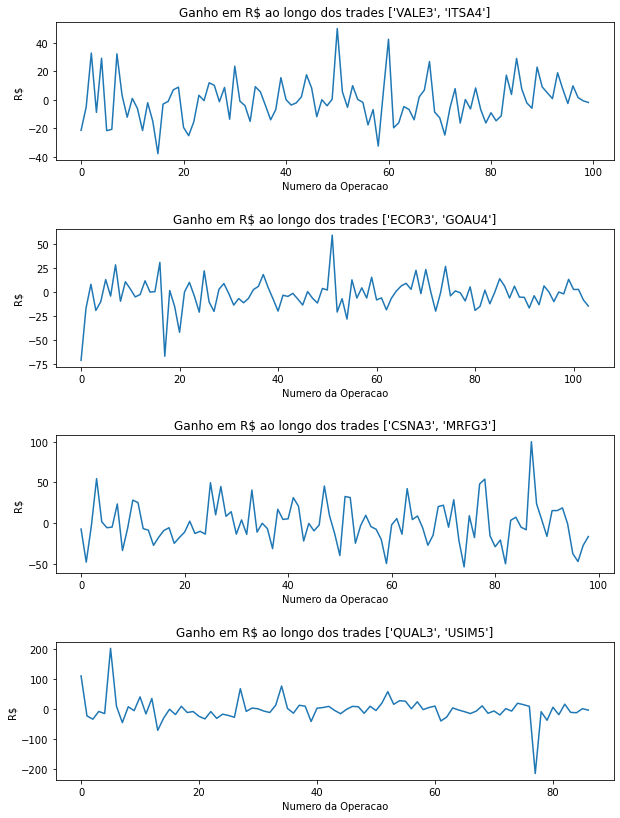

In [6]:
fig = plt.figure(figsize=(10, 25))
plt.subplots_adjust(left=None, bottom=0, right=None, top=None, wspace=None, hspace=.5)
contador1 = 1

for k,v in dic_dados_pares.items():
    print(f'{k}: {v.financeiro:.2f}')
    plt.subplot(8, 1, contador1)
    plt.title('Ganho em R$ ao longo dos trades '+ k)
    plt.xlabel('Numero da Operacao')
    plt.ylabel('R$')
    plt.plot(v.l_resultado)
    contador1 += 1

In [17]:
dados = pd.read_excel('C:/Users/danie/Desktop/mql_python/todos_diretorios_desenvolvimento_projeto/Relatório 1/dados_relatorio.xlsx')[2:] #windows

In [20]:
dic_dados_pares = {}

In [22]:
zsl = 1.1
tickers = [['close VALE3','close ITSA4'],['close ECOR3','close GOAU4'],['close CSNA3','close MRFG3'],['close QUAL3','close USIM5']] #['close VALE3','close ITSA4'],['close BBAS3','close BBSE3'],['close BBDC4','close ITUB4']
for i in tickers:
    dic_dados_pares[str(i)] = senninha_long_and_short(dados,i[0], i[1], 1000,zs_l = zsl)
    dic_dados_pares[str(i)].loop_operador(window_size=75)

['close VALE3', 'close ITSA4']: 1549.93
['close ECOR3', 'close GOAU4']: 2216.38
['close CSNA3', 'close MRFG3']: 2273.96
['close QUAL3', 'close USIM5']: 3288.94


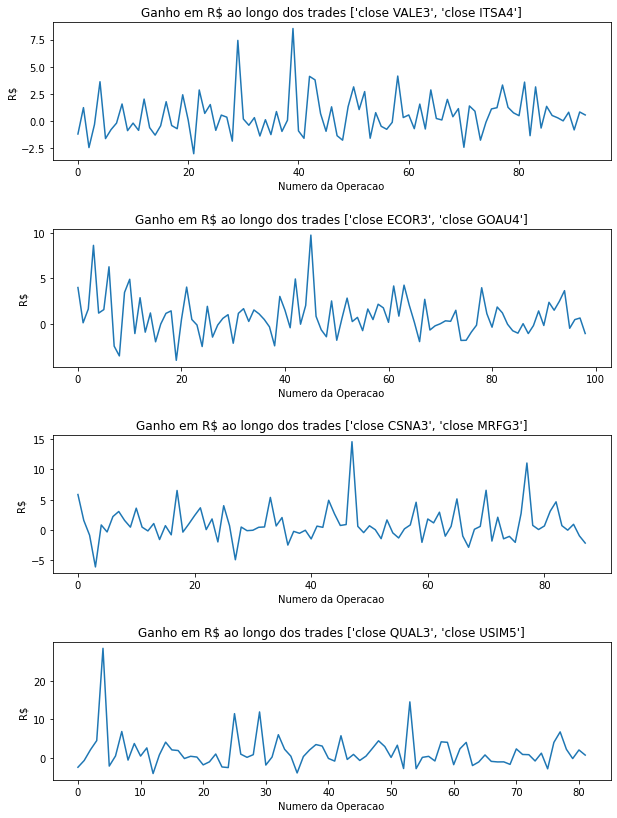

In [24]:
fig = plt.figure(figsize=(10, 25))
plt.subplots_adjust(left=None, bottom=0, right=None, top=None, wspace=None, hspace=.5)
contador1 = 1

for k,v in dic_dados_pares.items():
    print(f'{k}: {v.financeiro:.2f}')
    plt.subplot(8, 1, contador1)
    plt.title('Ganho em R$ ao longo dos trades '+ k)
    plt.xlabel('Numero da Operacao')
    plt.ylabel('R$')
    plt.plot(v.l_pct_operacoes)
    contador1 += 1

In [25]:
for k,v in dic_dados_pares.items():
    lista_dias_series = pd.Series(v.l_pct_operacoes)
    print(k,lista_dias_series.describe(),'\n |||||||||||||||||||||||||||||||||||||||||||')  

['close VALE3', 'close ITSA4'] count    93.000000
mean      0.513201
std       1.913653
min      -3.048212
25%      -0.792977
50%       0.283654
75%       1.282946
max       8.517679
dtype: float64 
 |||||||||||||||||||||||||||||||||||||||||||
['close ECOR3', 'close GOAU4'] count    99.000000
mean      0.836786
std       2.230047
min      -4.019620
25%      -0.412970
50%       0.466728
75%       1.697500
max       9.730274
dtype: float64 
 |||||||||||||||||||||||||||||||||||||||||||
['close CSNA3', 'close MRFG3'] count    88.000000
mean      0.985389
std       2.907962
min      -6.130699
25%      -0.465914
50%       0.580485
75%       1.866467
max      14.585857
dtype: float64 
 |||||||||||||||||||||||||||||||||||||||||||
['close QUAL3', 'close USIM5'] count    82.000000
mean      1.566392
std       4.424725
min      -4.057963
25%      -0.806423
50%       0.601992
75%       2.535873
max      28.343123
dtype: float64 
 |||||||||||||||||||||||||||||||||||||||||||
